# Doğrusal Regresyon ile Maaş Tahmini

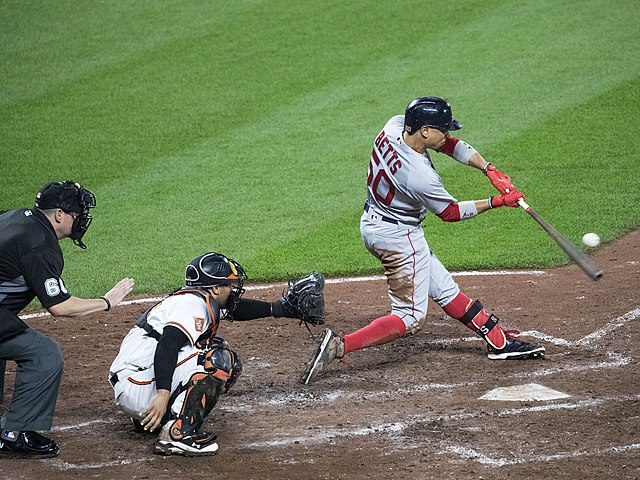

## İş Problemi

Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştiriniz.

## Veri Seti Hikayesi


Bu veri seti orijinal olarak Carnegie Mellon Üniversitesi'nde bulunan StatLib kütüphanesinden alınmıştır. Veri seti 1988 ASA Grafik Bölümü Poster Oturumu'nda kullanılan verilerin bir parçasıdır. Maaş verileri orijinal oalrak Sports Illustrated, 20 Nisan 1987'den alınmıştır. 1986 ve kariyer istatistikleri, Collier Books, Macmillan Publishing Company, New York tarafından yayınlanan 1987 Beyzbol Ansiklopedisi Güncellemesinden elde edilmiştir.

## Değişkenler

Veri seti içerisinde 20 adet değişken, 322 adet gözlem bulunmaktadır.

**-AtBat:** 1986-1987 sezonunda bir beyzbol sopası ile topa yapılan vuruş sayısı

**-Hits:** 1986-1987 sezonundaki isabet sayısı

**-HmRun:** 1986-1987 sezonundaki en değerli vuruş sayısı

**-Runs:** 1986-1987 sezonunda takımına kazandırdığı sayı

**-RBI:** Bir vurucunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısı

**-Walks:** Karşı oyuncuya yaptırılan hata sayısı

**-Years:** Oyuncunun major liginde oynama süresi (sene)

**-CAtBat:** Oyuncunun kariyeri boyunca topa vurma sayısı

**-CHits:** Oyuncunun kariyeri boyunca yaptığı isabetli vuruş sayısı

**-CHmRun:** Oyucunun kariyeri boyunca yaptığı en değerli sayısı

**-CRuns:** Oyuncunun kariyeri boyunca takımına kazandırdığı sayı

**-CRBI:** Oyuncunun kariyeri boyunca koşu yaptırdırdığı oyuncu sayısı

**-CWalks:** Oyuncun kariyeri boyunca karşı oyuncuya yaptırdığı hata sayısı

**-League:** Oyuncunun sezon sonuna kadar oynadığı ligi gösteren A ve N seviyelerine sahip bir faktör

**-Division:** 1986 sonunda oyuncunun oynadığı pozisyonu gösteren E ve W seviyelerine sahip bir faktör

**-PutOuts:** Oyun icinde takım arkadaşınla yardımlaşma

**-Assits:** 1986-1987 sezonunda oyuncunun yaptığı asist sayısı
**-Errors:** 1986-1987 sezonundaki oyuncunun hata sayısı

**-Salary:** Oyuncunun 1986-1987 sezonunda aldığı maaş(bin uzerinden)

**-NewLeague:** 1987 sezonunun başında oyuncunun ligini gösteren A ve N seviyelerine sahip bir faktör

## Görev

Data preprocessing ve feature engineering işlemleri gerçekleştirerek maaş tahmin modeli geliştiriniz
****

### Kütüphanalerin ve Fonksiyonların Tanımlanması

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve, \
    mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate
from statsmodels.stats.proportion import proportions_ztest

#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
#pd.set_option("display.float_format", lambda x: '%.3f' % x)
#pd.set_option("display.width", 500)

Fonksiyonları getirmek için oluşturduğumuz dosyalardan import işlemleri yapacağız

In [2]:
from funcs.data_prep import *
from funcs.eda import *

### Veri Setinin Yüklenmesi

In [3]:
df = pd.read_csv('datasets/hitters.csv')

Veri setini farklı açılardan inceleyelim.

In [4]:
check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 no

Veri setimizde 322 tane gözlem birimi, 20 tane de değişken bulunmakta. Bu değişkenlerin 3 tanesi kategorik, geri kalanı ise sayısal veri tipinde. 'Salary' değişkeni dışında hiçbir değişkende eksik değer bulunmuyor. Quantiles kısmında sayısal değişkenlerin istatistiklerini incelediğimizde, 'CAtBat' ve 'CHits' değişkenlerin çeyrek değerleri arasında yüksek sıçramalar görünüyor. Bu değişkenlerde aykırı değerler olabilir.

### Keşifçi Veri Analizi (EDA)

Veri setimizde detaylı analizler yapabilmemiz için bir kaç fonksiyondan yararlanacağız. Bu fonksiyonlara [github](https://github.com/hakanaydgmstr/miuul-machine-learning-summer-camp/tree/main/funcs) hesabımdan ulaşabilirsiniz.

Öncelikle kategorik ve sayısal değişkenleri ayrı ayrı analiz edebilmemiz için bu değişkenleri kendi aralarında ayırmamız gerekiyor. Bunun için *grab_col_names* fonksiyonundan yararlanacağız.

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


Veri setimizdeki 20 değişkenin 3'ü kategorik, 17'si nümerikmiş. İki tip değişkenleri de kendi içlerinde ayırdık.

In [6]:
cat_cols # kategorik değişkenler

['League', 'Division', 'NewLeague']

In [7]:
num_cols # nümerik değişkenler

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

Kategorik değişkenler için değişkenlerin frekanslarını ve oranlarını veren, ve countplot metodu ile grafiğini veren *cat_cols* fonksiyonunu kullanacağız.

   League      Ratio
A     175  54.347826
N     147  45.652174
#######################


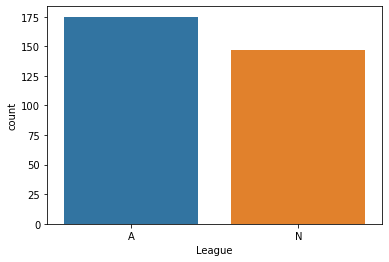

   Division      Ratio
W       165  51.242236
E       157  48.757764
#######################


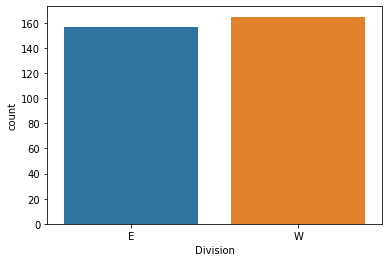

   NewLeague      Ratio
A        176  54.658385
N        146  45.341615
#######################


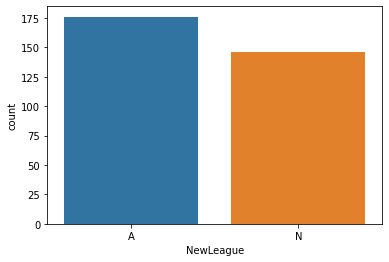

In [8]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

Kategorik değişkenlerin tümü ikişer sınıftan oluşmaktalar. Her bir sınıf dengeli bir şekilde dağılmış.

Nümerik değişkenlerin istatistiksel dağılımlarına detaylı bakmak için ise num_summary fonksiyonunu kullanacağız.

count    322.000000
mean     380.928571
std      153.404981
min       16.000000
5%       161.000000
10%      194.100000
20%      221.800000
30%      281.300000
40%      321.800000
50%      379.500000
60%      430.200000
70%      490.000000
80%      535.600000
90%      584.900000
95%      609.900000
99%      658.590000
max      687.000000
Name: AtBat, dtype: float64


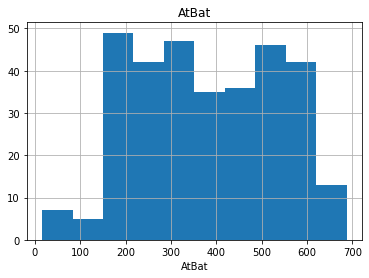

count    322.000000
mean     101.024845
std       46.454741
min        1.000000
5%        39.000000
10%       45.100000
20%       57.000000
30%       70.000000
40%       82.000000
50%       96.000000
60%      113.000000
70%      128.700000
80%      144.000000
90%      163.000000
95%      174.000000
99%      210.790000
max      238.000000
Name: Hits, dtype: float64


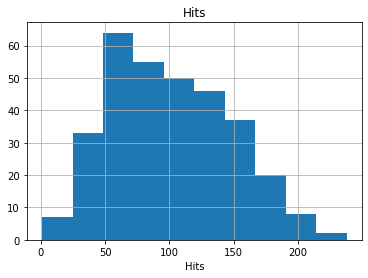

count    322.000000
mean      10.770186
std        8.709037
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        5.000000
40%        6.000000
50%        8.000000
60%       10.600000
70%       14.000000
80%       18.000000
90%       24.000000
95%       28.950000
99%       33.000000
max       40.000000
Name: HmRun, dtype: float64


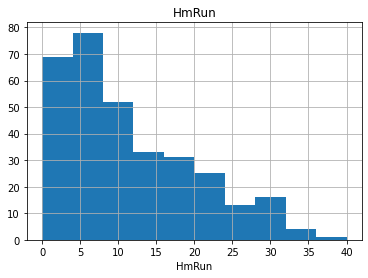

count    322.000000
mean      50.909938
std       26.024095
min        0.000000
5%        17.000000
10%       20.100000
20%       27.000000
30%       33.000000
40%       41.000000
50%       48.000000
60%       55.600000
70%       66.000000
80%       75.800000
90%       89.000000
95%       94.000000
99%      107.790000
max      130.000000
Name: Runs, dtype: float64


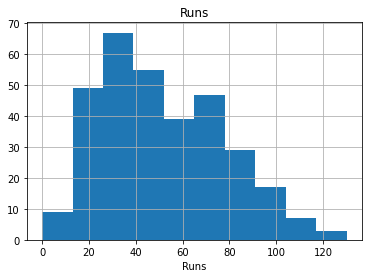

count    322.000000
mean      48.027950
std       26.166895
min        0.000000
5%        14.000000
10%       19.000000
20%       26.000000
30%       30.000000
40%       36.400000
50%       44.000000
60%       49.000000
70%       58.000000
80%       73.000000
90%       86.000000
95%       96.000000
99%      112.370000
max      121.000000
Name: RBI, dtype: float64


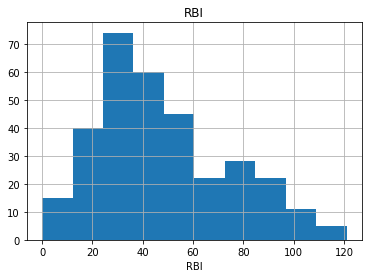

count    322.000000
mean      38.742236
std       21.639327
min        0.000000
5%        11.050000
10%       15.000000
20%       20.000000
30%       24.000000
40%       30.000000
50%       35.000000
60%       40.000000
70%       48.700000
80%       59.000000
90%       69.900000
95%       78.000000
99%       93.580000
max      105.000000
Name: Walks, dtype: float64


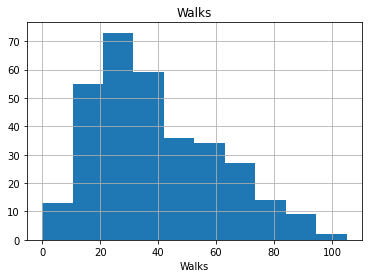

count    322.000000
mean       7.444099
std        4.926087
min        1.000000
5%         1.000000
10%        2.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        7.600000
70%       10.000000
80%       12.000000
90%       15.000000
95%       17.000000
99%       19.790000
max       24.000000
Name: Years, dtype: float64


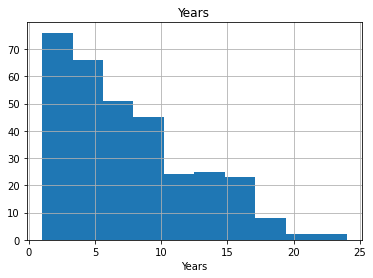

count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
5%         216.50000
10%        342.20000
20%        667.60000
30%        963.40000
40%       1402.20000
50%       1928.00000
60%       2654.00000
70%       3365.00000
80%       4483.00000
90%       6123.40000
95%       7125.60000
99%       8749.97000
max      14053.00000
Name: CAtBat, dtype: float64


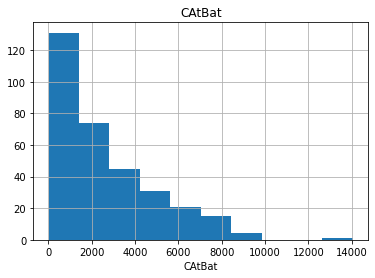

count     322.000000
mean      717.571429
std       654.472627
min         4.000000
5%         54.000000
10%        86.000000
20%       164.600000
30%       238.000000
40%       355.800000
50%       508.000000
60%       708.200000
70%       911.100000
80%      1229.200000
90%      1659.600000
95%      2017.150000
99%      2500.340000
max      4256.000000
Name: CHits, dtype: float64


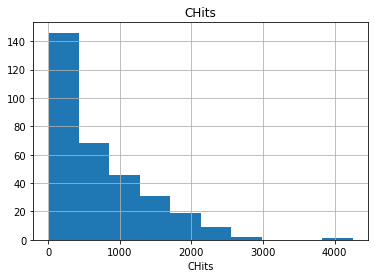

count    322.000000
mean      69.490683
std       86.266061
min        0.000000
5%         2.000000
10%        4.000000
20%       10.200000
30%       16.300000
40%       27.400000
50%       37.500000
60%       51.200000
70%       72.400000
80%      103.800000
90%      194.900000
95%      265.650000
99%      373.120000
max      548.000000
Name: CHmRun, dtype: float64


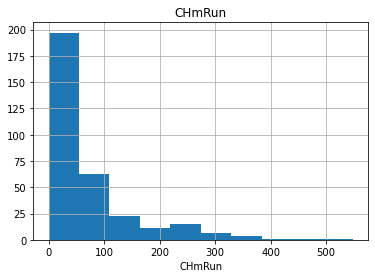

count     322.000000
mean      358.795031
std       334.105886
min         1.000000
5%         27.000000
10%        38.100000
20%        80.400000
30%       117.300000
40%       181.000000
50%       247.000000
60%       333.000000
70%       443.400000
80%       627.200000
90%       895.700000
95%      1032.300000
99%      1174.370000
max      2165.000000
Name: CRuns, dtype: float64


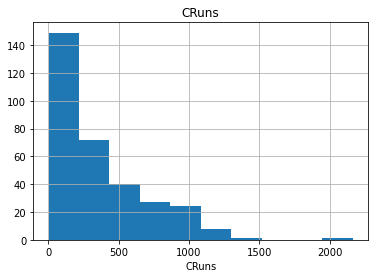

count     322.000000
mean      330.118012
std       333.219617
min         0.000000
5%         22.050000
10%        34.100000
20%        70.200000
30%       106.300000
40%       149.000000
50%       220.500000
60%       303.600000
70%       379.100000
80%       496.200000
90%       861.600000
95%      1071.750000
99%      1310.850000
max      1659.000000
Name: CRBI, dtype: float64


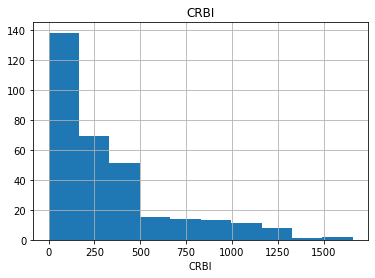

count     322.000000
mean      260.239130
std       267.058085
min         0.000000
5%         15.050000
10%        30.100000
20%        55.000000
30%        82.000000
40%       117.400000
50%       170.500000
60%       226.600000
70%       300.700000
80%       421.000000
90%       643.900000
95%       817.600000
99%      1139.140000
max      1566.000000
Name: CWalks, dtype: float64


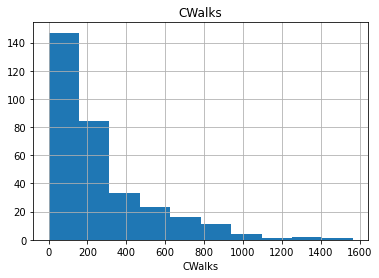

count     322.000000
mean      288.937888
std       280.704614
min         0.000000
5%         33.200000
10%        62.200000
20%        99.600000
30%       132.000000
40%       167.000000
50%       212.000000
60%       257.400000
70%       303.000000
80%       365.800000
90%       685.600000
95%       910.650000
99%      1301.190000
max      1378.000000
Name: PutOuts, dtype: float64


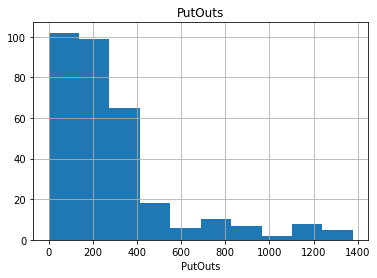

count    322.000000
mean     106.913043
std      136.854876
min        0.000000
5%         0.000000
10%        2.000000
20%        5.200000
30%        9.000000
40%       15.400000
50%       39.500000
60%       76.800000
70%      134.800000
80%      210.800000
90%      353.300000
95%      431.450000
99%      478.160000
max      492.000000
Name: Assists, dtype: float64


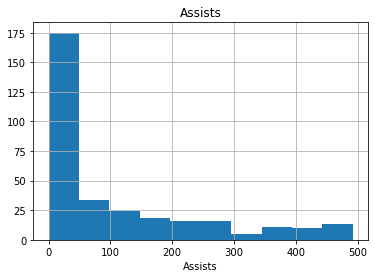

count    322.000000
mean       8.040373
std        6.368359
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        8.000000
70%       10.000000
80%       13.000000
90%       17.000000
95%       20.000000
99%       25.790000
max       32.000000
Name: Errors, dtype: float64


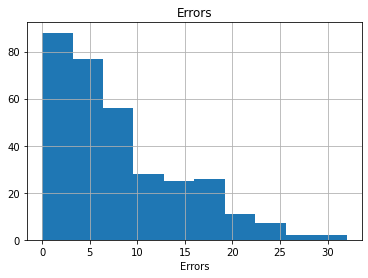

count     263.000000
mean      535.925882
std       451.118681
min        67.500000
5%         86.600000
10%       100.000000
20%       155.000000
30%       221.000000
40%       300.000000
50%       425.000000
60%       538.000000
70%       700.000000
80%       809.000000
90%      1048.666600
95%      1346.000000
99%      2032.886540
max      2460.000000
Name: Salary, dtype: float64


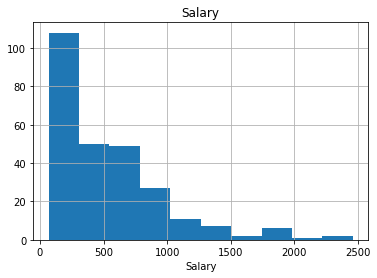

In [9]:
for col in num_cols:
    num_summary(df, col, plot=True)

Genel olarak istatistikleri değerlendirdiğimizde nümerik değişkenlerde outlier içeren değişkenler var gibi duruyor. Ayrıca grafikler incelendiğinde çoğu değişkende yığılma var. Bu problemleri çözmek için detaylı outlier analizi yapmamız gerekiyor.

**Outlier Analizi**

Öncelikle bağımlı değişkenimizdeki verilerin dağılımını görmek için boxplot yöntemini kullanacağız, ki outlier değer varsa gözlemleyebilelim.

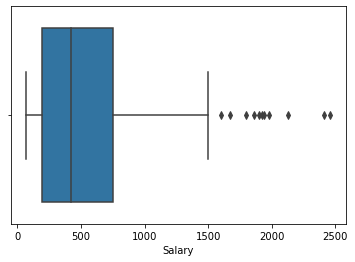

In [10]:
sns.boxplot(x="Salary", data=df)

Bağımlı değişkenimizin üst limit değeri 1400 civarlarında gözüküyor. Bunun üstündeki nokta ile belirlenen değerler outlier değerleri olarak görülmekte. Bu değerleri istersek bir threshold değeri belirleyip bu değer ile baskılayabiliriz, fakat bağımlı değişken üzerinde yapacağımız herhangi bir değişiklik veri kaybına neden olabilir. Bu da modelimizin başarısını kötü yönde etkileyebilir. Dolayısıyla değerler üzerinde değişiklik yapmak yerine, bu değerleri veri setimizden çıkartmak çok daha iyi bir çözüm olacaktır.

Bunun için fancy index yardımıyla, 1400 olarak belirlediğimiz değerden daha yüksek maaş değeri barındıran indexleri seçip, bunları veri setinden drop edebiliriz.

In [11]:
outlier_index = df[df["Salary"] > 1400].index

In [12]:
outlier_index

Int64Index([82, 84, 96, 100, 110, 112, 163, 179, 217, 229, 248, 278, 313], dtype='int64')

In [13]:
df = df.drop(outlier_index)

Outlier barındıran indexleri veri setinden dropladık. Bağımlı değişkenimizi tekrar inceleyelim.

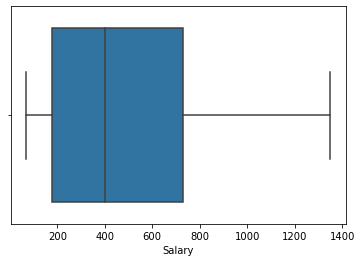

In [14]:
sns.boxplot(x="Salary", data=df)

Görüldüğü gibi aykırı değerlerden kurtulmuş olduk.

Şimdi aynı işlemleri bağımsız değişkenler için yapalım. Öncelikle *check_outlier* fonksiyonu ile bağımsız değişkenlerimiz üzerinde aykırı değer sorgusu yapacağız. Bu sorgu işleminden önce öncelikle outlier değerler için üst ve alt limit belirlememiz gerekiyor. Fonksiyon içerisinde default olarak 0.25-0.75 oranları seçili. Yani bu, veri seti içerisinde %25 çeyrekliğin altındaki ve %75 çeyrekliğinin üzerideki değerleri outlier kabul et demektir. Fakat bu oranlar şu anki veri setimiz için yüksek oranlar, veri setimizde az miktarda gözlem birimi bulunuyor. Bunun için biz 0.1-0.9 oranlarını kullanacağız.

In [15]:
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.1, q3 =0.9))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns True
CRBI False
CWalks True
PutOuts False
Assists False
Errors False
Salary False


'CHits', 'CHmRun', 'CRuns' ve 'CWalks' değişkenlerinde aykırı değerler olduğu görülüyor. Bu değişkenleri ayrı bir liste içerisinde tutalım ki sonrasında bir işlem yaparsak eğer kolay bir şekilde erişebilelim.

In [16]:
outlier_features = ["CHits", "CHmRun", "CRuns", "CWalks"]

Aykırı değer analizlerinden sonra eksik değerlere daha detaylı olarak bakabiliriz.

**Eksik Değerler**

Projenin başında özet tabloya baktığımızda sadece 'Salary' değişkeninde, yani bağımlı değişkenimizde eksik veri vardı.

In [17]:
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Eksik değerleri çözmek için birçok yöntem bulunmakta. Bunlardan herhangi birini kullanabiliriz fakat bu projemizde eksik değerler bağımlı değişkenimizde bulunuyor. Bağımlı değişken içerisinde herhangi bir veri değişikliği, model sonucumuzu direkt olarak etkileyecektir. Bundan dolayı bu eksik verileri doldurmak yerine, eksik değer bulunduran satırları silmek, en doğru hareket olacaktır.

In [18]:
df = df.dropna()

In [19]:
df.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

Eksik değerleri de böylece halletmiş oluyoruz. Veri seti üzerindeki analizlerimizi tamamladık. Şimdi kategorik değişkenlerin encode işlemlerini yapalım.

### Encoding

Burada *one_hot_encoding* fonksiyonunu kullanacağız. Bu fonksiyon pandas'ın get_dummies metodunu kullanmaktadır. Dolayısıyla tek bir fonksiyon ile hem label encoding, hem de one-hot encoding işlemini gerçekleştirebiliriz.

In [20]:
df = one_hot_encoder(df, cat_cols) # fonksiyon içerisinde drop_first parametresinin default değeri True.

In [21]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


### Feature Engineering

**Base Model**

Herhangi bir feature extraction işleminden önce modeli kıyaslayabilmek adına bir base model kurulumu yapalım. Böylece ileride yeni featurelar ile kurduğumuz modelin başarı ve hatalarını geri dönüp karşılaştırabiliriz.

Model kurmadan önce aykırı değerleri halledelim. Burada aykırı değerleri threshold değerleri ile değiştireceğiz. Bunun için *replace_with_thresholds* fonksiyonunu kullanacağız.

In [22]:
for col in outlier_features:
    replace_with_thresholds(df, col)

Bu projede Linear Regression modelini kullanacağız. Öncelikle bağımlı ve bağımsız değişkenlerimizi ayıralım.

In [23]:
y = df["Salary"]
X = df.drop("Salary", axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
lin_reg = LinearRegression()

In [27]:
lin_reg.fit(X_train, y_train)

LinearRegression()

Modelimizi kurduk. Modeli değerlendirmek için train ve test verileri üzerinden R kare ve RMSE skorlarına bakacağız.

In [28]:
print(f"Train R2: {lin_reg.score(X_train, y_train)}")
print(f"Test R2: {lin_reg.score(X_test, y_test)}")

Train R2: 0.5229582025713209
Test R2: 0.6064747928582755


RMSE skoru için hem train verilerinden hem de test verilerinden tahminler almamız gerekiyor.

In [29]:
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [30]:
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")

Train RMSE: 218.0691974244055
Test RMSE: 234.80961064543888


Base modelimizin sonuçlarını incelediğimizde, modelimiz train veri setinde %52 doğrulukta çalışmaktayken, test veri setinde %60 doğrulukta çalışıyor. Ayrıca train verilerinden elde ettiğimiz RMSE skoru 218.07 iken, test verilerinden elde edilen RMSE skoru 234.8. Bu sonuçlar, veri setinde modelimizi iyi bir şekilde eğitecek kadar gözlem olmadığını gösteriyor. Yani modelimiz *underfit* etmiş.

Bu durumun önüne geçebilmek için veri setinde yeni featurelar oluşturacağız.

**Feature Extraction**

Yeni değişkenler üretirken iş bilgisi son derece önemlidir. Projenin konusu hakkında ne kadar bilgi sahibi olunursa; hangi değişkenlerden neler çıkabilir, hangi iki değişken birlikte kullanılabilir vs. gibi sorulara çok rahat yanıt verilebilir.

Bu işlemden önce daha rahat çalışabilmek adına veri seti içerisindeki tüm değişkenlerin isimlerini büyük harfler ile değiştirelim.

In [31]:
df.columns = [col.upper() for col in df.columns]

In [32]:
df.head()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,CRUNS,CRBI,CWALKS,PUTOUTS,ASSISTS,ERRORS,SALARY,LEAGUE_N,DIVISION_W,NEWLEAGUE_N
1,315,81,7,24,38,39,14,3449,835.0,69.000,321.0,414,375.0,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457.0,63.000,224.0,266,263.0,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575.0,186.125,828.0,838,354.0,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101.0,12.000,48.0,46,33.0,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133.0,19.000,501.0,336,194.0,282,421,25,750.0,0,1,0


Aşağıda, veri setindeki birkaç değişkeni bir arada kullanarak birkaç feature oluşturmak için işlemler gerçekleştirildi. 

In [33]:
# oyuncunların major ligdeki oynadığı yıla göre deneyim verileri
df.loc[(df["YEARS"] <= 2), 'NEW_YEARS_CAT'] = 'rookie'
df.loc[(df["YEARS"] > 2) & (df["YEARS"] <= 6), 'NEW_YEARS_CAT'] = 'junior'
df.loc[(df["YEARS"] > 6) & (df["YEARS"] <= 14), 'NEW_YEARS_CAT'] = 'senior'
df.loc[(df["YEARS"] > 14), 'NEW_YEARS_CAT'] = 'veteran'

# oyuncuların saha içerisinde takım lehine yaptığı etkinlikleri bir işleme sokarak oluşturulan değişken
df["NEW_RUNS_WALKS_ASSISTS"] = df["RUNS"] * df["WALKS"] * df["ASSISTS"]

# yukarıdaki değişkenin değerine göre oyunculara bir performans skoru veren değişken
df["NEW_RWA_PERFORMANCE"] = pd.qcut(df["NEW_RUNS_WALKS_ASSISTS"], 4, labels=["D", "C", "B", "A"])

# oyuncuların sezon içerisinde yaptığı isabetli vuruşların, sezon içerisinde yaptığı toplam vuruşlara oranı (accuracy)
df["NEW_ATBAT_HITS_ACCURACY"] = df["HITS"] / df["ATBAT"]

# yukarıdaki aynı accuracy oranını kariyer boyunca yapılan isabetli vuruş ve toplam vuruş için oluşturulan değişken
df["NEW_CATBAT_CHITS_ACCURACY"] = df["CHITS"] / df["CATBAT"]

# yukarıda hesapladığımız iki accuracy değerlerini kategorik olan tutan değişkenler
df["NEW_CATBAT_CHITS_ACCURACY_CAT"] = pd.qcut(df["NEW_CATBAT_CHITS_ACCURACY"], 3, labels=["low", "medium", "high"])
df["NEW_ATBAT_HITS_ACCURACY"] = pd.qcut(df["NEW_ATBAT_HITS_ACCURACY"], 3, labels=["low", "medium", "high"])

In [34]:
df.head()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,...,SALARY,LEAGUE_N,DIVISION_W,NEWLEAGUE_N,NEW_YEARS_CAT,NEW_RUNS_WALKS_ASSISTS,NEW_RWA_PERFORMANCE,NEW_ATBAT_HITS_ACCURACY,NEW_CATBAT_CHITS_ACCURACY,NEW_CATBAT_CHITS_ACCURACY_CAT
1,315,81,7,24,38,39,14,3449,835.0,69.000,...,475.0,1,1,1,senior,40248,C,medium,0.242099,low
2,479,130,18,66,72,76,3,1624,457.0,63.000,...,480.0,0,1,0,junior,411312,A,medium,0.281404,high
3,496,141,20,65,78,37,11,5628,1575.0,186.125,...,500.0,1,0,1,senior,26455,C,high,0.279851,high
4,321,87,10,39,42,30,2,396,101.0,12.000,...,91.5,1,0,1,rookie,46800,C,medium,0.255051,medium
5,594,169,4,74,51,35,11,4408,1133.0,19.000,...,750.0,0,1,0,senior,1090390,A,high,0.257033,medium


Yukarıda yaptığımız encode işleminin aynısını şimdi yine yapmamız gerekiyor. Bunun için kategorik ve sayısal değişkenleri tekrar en baştan ayırmamız gerekiyor.

In [35]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 250
Variables: 26
cat_cols: 4
num_cols: 19
cat_but_car: 0
num_but_cat: 0


In [36]:
cat_cols

['NEW_YEARS_CAT',
 'NEW_RWA_PERFORMANCE',
 'NEW_ATBAT_HITS_ACCURACY',
 'NEW_CATBAT_CHITS_ACCURACY_CAT']

In [37]:
df = one_hot_encoder(df, cat_cols)

In [38]:
df.head()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,...,NEW_YEARS_CAT_rookie,NEW_YEARS_CAT_senior,NEW_YEARS_CAT_veteran,NEW_RWA_PERFORMANCE_C,NEW_RWA_PERFORMANCE_B,NEW_RWA_PERFORMANCE_A,NEW_ATBAT_HITS_ACCURACY_medium,NEW_ATBAT_HITS_ACCURACY_high,NEW_CATBAT_CHITS_ACCURACY_CAT_medium,NEW_CATBAT_CHITS_ACCURACY_CAT_high
1,315,81,7,24,38,39,14,3449,835.0,69.000,...,0,1,0,1,0,0,1,0,0,0
2,479,130,18,66,72,76,3,1624,457.0,63.000,...,0,0,0,0,0,1,1,0,0,1
3,496,141,20,65,78,37,11,5628,1575.0,186.125,...,0,1,0,1,0,0,0,1,0,1
4,321,87,10,39,42,30,2,396,101.0,12.000,...,1,0,0,1,0,0,1,0,1,0
5,594,169,4,74,51,35,11,4408,1133.0,19.000,...,0,1,0,0,0,1,0,1,1,0


In [39]:
df.shape

(250, 32)

Projenin başında veri setimizde 322 tane gözlem ve 20 tane değişken vardı. Analiz ve feature engineering süreçlerimizden sonra 250 tane gözlemimiz, 32 tane değişkenimiz bulunuyor.

### Model

**Holdout**

In [40]:
y = df["SALARY"]
X = df.drop("SALARY", axis=1)

In [41]:
scaler = RobustScaler()

In [42]:
#X = scaler.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
lin_reg = LinearRegression()

In [45]:
lin_reg.fit(X_train, y_train)

LinearRegression()

Model kuruldu. Şimdi sonuçları analiz edelim.

In [46]:
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [47]:
print(f"Train R2: {lin_reg.score(X_train, y_train)}")
print(f"Test R2: {lin_reg.score(X_test, y_test)}")

Train R2: 0.6202580652327738
Test R2: 0.6811081302791031


In [48]:
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")

Train RMSE: 194.56306009679926
Test RMSE: 211.3738772325832


### Sonuç

Feature engineering yapmadığımız zamanki model sonuçları:

- <b>Train R2</b>: 0.5229582025713209
- <b>Test R2</b>: 0.6064747928582755
- <b>Train RMSE</b>: 218.0691974244055
- <b>Test RMSE</b>: 234.80961064543888

Yeni featurelar oluşturduktan sonra kurduğumuz modelin sonuçları:

- <b>Train R2</b>: 0.6202580652327738
- <b>Test R2</b>: 0.6811081302791031
- <b>Train RMSE</b>: 194.56306009679926
- <b>Test RMSE</b>: 211.3738772325832

Sonuçları incelediğimizde yeni ürettiğimiz featurelar ile modelimizin hem train veri seti üzerinden hem de test veri seti üzerinden daha iyi sonuçlar vermiş olduğunu görüyoruz. İki veri setinde de R kare skorları artmış, hata değerleri ise düşüş göstermiştir.

Fakat feature engineering işleminden sonra bile, ilk modele göre performans artışı yaşansa da, aslında R kare değerleri hala düşük, RMSE skorları ise hala yüksektir. Yani model hala *underfit* etmekte. Bu noktada olası daha fazla feature üretmek veya veri setindeki gözlem sayısını arttırmak bu probleme çözüm olabilir.

Yeni modelimizde bizim ürettiğimiz değişkenlerin ne oranda modeli etkilediğini gözlemleyebilmek için aşağıdaki fonksiyonu kullanabiliriz. Bu fonksiyonda modelden, her bir değişkenin coefficient değerlerini alarak bunların büyüklüğüne göre bir grafik çizdireceğiz.

In [49]:
# oluşturduğumuz modelde, modele verdiğimiz değişkenlerden hangilerinin ne kadar etkili olduğunu çizdiren grafik fonksiyonu
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Coefficient': model.coef_, 'Feature': features.columns})
    print(feature_imp.sort_values("Coefficient", ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Coefficient", y="Feature", data=feature_imp.sort_values(by="Coefficient",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

    Coefficient                               Feature
22   167.077520                  NEW_YEARS_CAT_senior
30   108.850205    NEW_CATBAT_CHITS_ACCURACY_CAT_high
16    66.367396                              LEAGUE_N
29    50.921836  NEW_CATBAT_CHITS_ACCURACY_CAT_medium
25    29.478834                 NEW_RWA_PERFORMANCE_B
9      2.740411                                CHMRUN
2      2.489036                                 HMRUN
5      2.390698                                 WALKS
1      1.687269                                  HITS
10     0.284891                                 CRUNS
0      0.191964                                 ATBAT
14     0.161823                               ASSISTS
13     0.132471                               PUTOUTS
27     0.108109        NEW_ATBAT_HITS_ACCURACY_medium
7      0.060984                                CATBAT
8      0.033787                                 CHITS
19     0.000004                NEW_RUNS_WALKS_ASSISTS
12    -0.150797             

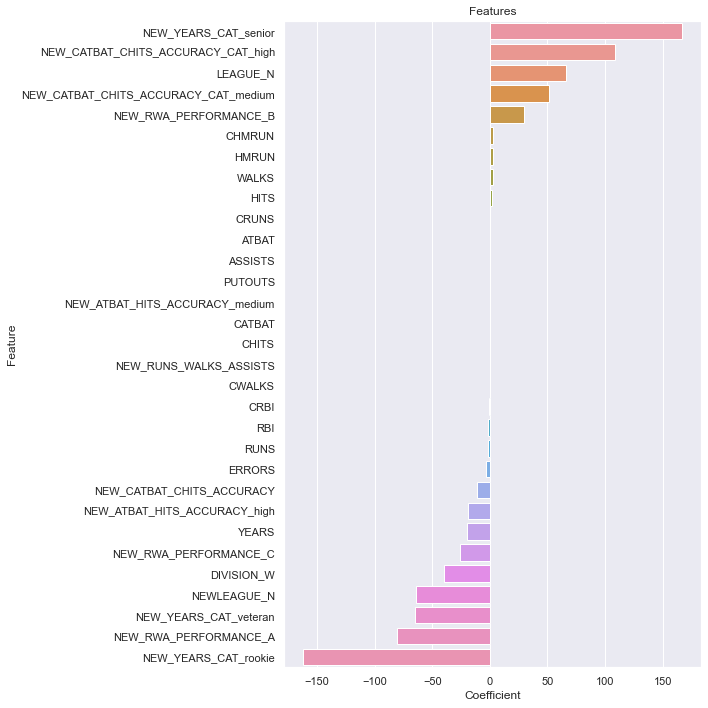

In [50]:
plot_importance(lin_reg, X_train)